# This notebook will use pyTorch to classify the componentX 
We will use pyTorch and the Transformer architecture to do classifications of the life time for Component X.

In [4]:
#Includes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F


In [5]:
#Read the raw data
#Train data
tteTrain = pd.read_csv('../data/train_tte.csv')
specificationsTrain = pd.read_csv('../data/train_specifications.csv')
readoutsTrain = pd.read_csv('../data/train_operational_readouts.csv')


#Validation data
labelsValidation = pd.read_csv('../data/validation_labels.csv')
specificationsValidation = pd.read_csv('../data/validation_specifications.csv')
readoutsValidation = pd.read_csv('../data/validation_operational_readouts.csv')

#Test data
specificationsTest = pd.read_csv('../data/test_specifications.csv')
readoutsTest = pd.read_csv('../data/test_operational_readouts.csv')
#No labels for test data yet


In [6]:
#First we group by vehicle_id and we will forward fill the last known value.
#Then if the entire column is NaN, we will fill it with the median of the column. 
#If there are still any NaNs we will fill them with 0.

def fill_missing_values(df):
    df = df.groupby('vehicle_id').apply(lambda x: x.ffill(axis=0)) #Forward fill last known value, but only for the same vehicle
    df = df.droplevel('vehicle_id') #Remove multi-index, as we don't want to group by vehicle_id anymore    
    df = df.fillna(df.median()) #Fill with median rather than mean to avoid outliers
    df = df.fillna(0) #Last resort fill with 0
    
    return df

In [4]:
# #df is the dataframe containing categorical values
# #possible_categories is a dictionary with the column name as the key and the possible categories as the values
# def one_hot_encoding_fixed_columns(df, possible_categories):
    
#     #Create all possible combinations of the columns and categories
#     source_columns = list(possible_categories.keys())
#     cols = [f'{col}_{cat}' for col in source_columns for cat in possible_categories[col]]
    
#     #Create a dataframe with the fixed columns with zeros, using the index of df as the index
#     one_hot_encoded = pd.DataFrame(0, index=df.index, columns=cols, dtype=np.float32) 
    
#     # Get dummies dataset
#     dummies_df = pd.get_dummies(df,columns=source_columns, dtype=np.float32)

#     # Make sure columns exists in both dataframes    
#     cols_in_both = dummies_df.columns.intersection(cols)

#     #Copy the one hot encoded columns to the fixed columns
#     one_hot_encoded[cols_in_both] = dummies_df[cols_in_both]

    
#     return one_hot_encoded

In [20]:
def handle_specifications(specificationsdf):
    #Possible categories for the specifications
    possible_categories = {
        'Spec_0': ['Cat0', 'Cat1', 'Cat2'],
        'Spec_1': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16', 'Cat17', 'Cat18', 'Cat19',  'Cat20', 'Cat21', 'Cat22', 'Cat23', 'Cat24', 'Cat25', 'Cat26', 'Cat27', 'Cat28'],
        'Spec_2': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16', 'Cat17', 'Cat18', 'Cat19', 'Cat20'],
        'Spec_3': ['Cat0', 'Cat1', 'Cat2', 'Cat3'],
        'Spec_4': ['Cat0', 'Cat1'],
        'Spec_5': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4'],
        'Spec_6': ['Cat0', 'Cat1','Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat15', 'Cat17', 'Cat18' ],
        'Spec_7': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8']
    }


    #Create a conversion table for the categories, so that Cat0 is 0, Cat1 is 1, etc.
    conversion_table = {}
    for key in possible_categories.keys():
        conversion_table[key] = {possible_categories[key][i]: i for i in range(len(possible_categories[key]))}

    df = specificationsdf.copy()
    
    for key in conversion_table.keys():
        df[key] = df[key].map(conversion_table[key])

    #Num categories per feature:
    num_categories_per_spec = [len(possible_categories[key]) for key in possible_categories.keys()]


    return df, num_categories_per_spec


    

In [38]:
def add_features(readoutsdf, specificationsdf):
    df = readoutsdf.copy()

    #Convert specifications to integer-based categories
    specificationsdf, num_categories_per_spec = handle_specifications(specificationsdf)

    # Join the specifications for the vehicles, 
    df = pd.merge(df, specificationsdf, on = 'vehicle_id', how='left')

    return df, num_categories_per_spec

In [39]:
df = readoutsTrain.copy()
df = fill_missing_values(df) 
  
#Add features
df, num_categories_per_spec = add_features(df, specificationsTrain)

In [40]:
df.tail()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_34,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
1122447,33643,101.0,2136810.0,41412.0,81068654.0,10365.0,843.0,6408272.0,10964376.0,6092347.0,...,17033.0,24.0,0,0,2,0,0,0,1,4
1122448,33643,107.0,2283285.0,44660.0,86639835.0,12317.0,843.0,6596477.0,12358026.0,6721702.0,...,18901.0,24.0,0,0,2,0,0,0,1,4
1122449,33643,113.8,2462865.0,48370.0,93439419.0,13910.0,843.0,6669542.0,12830421.0,7415497.0,...,21237.0,28.0,0,0,2,0,0,0,1,4
1122450,33643,119.8,2627250.0,51101.0,99682931.0,14854.0,843.0,7074468.0,13604706.0,7747492.0,...,22357.0,32.0,0,0,2,0,0,0,1,4
1122451,33643,125.8,2741460.0,52949.0,104122894.0,15222.0,843.0,7988418.0,16274631.0,8095988.0,...,23453.0,32.0,0,0,2,0,0,0,1,4


In [32]:
# We want to create labels for the training data based on the time to event data
# Labels in validation set are denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively. 
# If we don't have a failure reported, and the time_step left is less 48 we don't know when the failure will happen, so we will label it as -1. 

def get_class_label_train(row):
    #classes denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively
    if row['time_to_potential_event'] > 48:
        return 0 #No failure within 48 time steps
    elif row['time_to_potential_event'] > 24 and row['in_study_repair'] == 1:
        return 1 #Failure within 48 to 24 time steps
    elif row['time_to_potential_event'] > 12 and row['in_study_repair'] == 1:
        return 2 #Failure within 24 to 12 time steps
    elif row['time_to_potential_event'] > 6 and row['in_study_repair'] == 1:
        return 3 #Failure within 12 to 6 time steps
    elif row['time_to_potential_event'] > 0 and row['in_study_repair'] == 1:
        return 4 #Failure within 6 to 0 time steps
    else:
        return -1 #No failure reported, but within 48 time steps from the end of the study, don't know if it will fail or not
    
def add_class_labels_train(ttedf, readoutsdf):
    # Join the readouts and the time to event data
    df = pd.merge(readoutsdf, ttedf, on = 'vehicle_id', how='left').copy()

    #Calculate the time to a failure event
    df['time_to_potential_event'] = df['length_of_study_time_step'] - df['time_step']

    df['class_label'] = df.apply(get_class_label_train, axis=1)

    return df

In [33]:
# We want to create labels for the training data based on the time to event data
# Labels in validation set are denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively. 
# The validation_labels.csv file has 5046 rows, which is equal to the number of vehicles contributed to the operational data of the
# validation set. It includes a column named class_label, corresponding to the class for the last readout of each vehicle.
# As mentioned in subsection validation_operational_readouts.csv, the last readout for the validation set is selected randomly
# among all readouts for each vehicle. The temporal placement of this final simulated readout is categorized into five classes
# denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12
# to 6), and (6 to 0) time_step before the failure, respectively. These classes show the time windows in which the last readouts for
# each vehicle are randomly selected.

def get_class_label_validation(row):
    #classes denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively
    dt = row['time_to_potential_event'] #Time left to the end of the time series

    #Add time based on the class_labels
    if row['class_label'] == 0:
        #(48+) after last readout
        dt += 48
    elif row['class_label'] == 1:
        #(48 to 24) after last readout
        dt += 24
    elif row['class_label'] == 2:
        #(24 to 12) after last readout
        dt += 12
    elif row['class_label'] == 3:
        #(12 to 6) after last readout
        dt += 6
    elif row['class_label'] == 4:
        #(6 to 0) after last readout
        dt += 0


    if dt >= 48:
        return 0 #No failure within 48 time steps
    elif dt >= 24:
        return 1 #Failure within 48 to 24 time steps
    elif dt >= 12:
        return 2 #Failure within 24 to 12 time steps
    elif dt >= 6:
        return 3 #Failure within 12 to 6 time steps
    elif dt >= 0:
        return 4 #Failure within 6 to 0 time steps
    else:
        return -1 #Should not happen...
    
def add_class_labels_validation(ttedf, readoutsdf):
    # Join the readouts and the time to event data
    df = pd.merge(readoutsdf, ttedf, on = 'vehicle_id', how='left').copy()

    # For each vehicle get the max time_step seen for that vehicle:
    df['length_of_study_time_step'] = df.groupby('vehicle_id')['time_step'].transform('max')

    #Calculate the time to a failure event
    df['time_to_potential_event'] = df['length_of_study_time_step'] - df['time_step']

    df['class_label'] = df.apply(get_class_label_validation, axis=1)

    return df

In [52]:
#This function will preprocess all the data step by step and return X and y
def preprocess_all(readoutsdf, specificationsdf, ttedf=None, validation=False):
    #Fill missing values
    df = fill_missing_values(readoutsdf) 
  
    #Add features

    df, num_categories_per_spec = add_features(df, specificationsdf)

    #We only have information about the class labels in the training and validation data
    if ttedf is not None:

        #Merge the time to event data with the readouts data and figure out which class they belong to
        #Later we will need to remove the columns: length_of_study_time_step, in_study_repair, time_to_potential_event, class_label and remove any rows with class label -1

        #Train and validation targets are structured in different ways, needs to be handled differently
        if validation:
            df = add_class_labels_validation(ttedf, df)
            #Drop the columns that we cannot use for training, since they contain information about the class label
            df = df.drop(columns = ['length_of_study_time_step', 'time_to_potential_event'])
        else:
            df = add_class_labels_train(ttedf, df)
            #Drop the columns that we cannot use for training, since they contain information about the class label
            df = df.drop(columns = ['length_of_study_time_step', 'in_study_repair', 'time_to_potential_event'])

        # Remove classes with class -1, where we don't know if the vehicle will fail or not within 48 hours
        df = df[df['class_label'] != -1]

    # categoryColumns = [col for col in specificationsdf.columns if 'Spec' in col]
    
    # dfCategories = df[categoryColumns] #Take only the columns that are categories
    # df = df.drop(columns = categoryColumns) #Drop the columns that are categories
  
    return df, num_categories_per_spec

In [11]:
labelsValidation.head()

,vehicle_id,class_label
0,10,0
1,16,0
2,18,0
3,23,0
4,45,0


In [53]:

dfTrain, num_categories_per_spec = preprocess_all(readoutsTrain, specificationsTrain, tteTrain, validation=False)
dfValidation, _ = preprocess_all(readoutsValidation, specificationsValidation, labelsValidation, validation=True)
dfTest, _ = preprocess_all(readoutsTest, specificationsTest)
#dfTrain, XTrain, yTrain = preprocess_all(readoutsTrain, specificationsTrain, tteTrain, validation=False)
# XValidation, yValidation = preprocess_all(readoutsValidation, specificationsValidation, labelsValidation, validation=True)
# XTest, yTest = preprocess_all(readoutsTest, specificationsTest)

In [54]:
dfTrain.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,452.0,0,0,0,0,0,0,0,0,0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,452.0,0,0,0,0,0,0,0,0,0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,4111.0,1302855.0,1628265.0,630345.0,...,452.0,0,0,0,0,0,0,0,0,0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,4111.0,1302855.0,1628265.0,630345.0,...,453.0,0,0,0,0,0,0,0,0,0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,4111.0,1302855.0,1628265.0,630345.0,...,454.0,0,0,0,0,0,0,0,0,0


In [55]:
# Use Scikit-learn to normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#Normalize the data, but only the columns that are not one hot encoded
colsToIgnore = ['vehicle_id', 'class_label', 'Spec']
#Get the columns that we don't ignore
columns = [col for col in dfTrain.columns if all(ignored not in col for ignored in colsToIgnore)]

#Fit and transform the data
dfTrain[columns] = scaler.fit_transform(dfTrain[columns])

#Use the same transformation for the validation and test data
dfValidation[columns] = scaler.transform(dfValidation[columns])
dfTest[columns] = scaler.transform(dfTest[columns])

In [56]:
dfTrain.describe()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
count,919315.000000,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,...,9.193150e+05,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000
mean,15206.614850,1.310846e-16,-5.441248e-17,-2.671158e-17,-6.381100e-17,-3.462612e-18,3.920172e-17,3.227649e-17,-5.564913e-17,-3.932538e-17,...,-2.012643e-17,0.190648,3.816901,1.747000,0.610904,0.016777,0.307290,1.157302,1.944170,0.054272
std,9774.004888,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,0.395990,5.026650,2.514605,0.916742,0.128434,0.713147,1.560122,2.253661,0.368800
min,0.000000,-1.436019e+00,-1.193171e+00,-8.203732e-01,-1.237974e+00,-5.394333e-01,-2.757221e-01,-1.178886e+00,-1.079403e+00,-9.028752e-01,...,-2.262132e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6247.000000,-7.990563e-01,-7.675430e-01,-6.320502e-01,-7.657070e-01,-5.071259e-01,-2.713850e-01,-7.250011e-01,-6.907598e-01,-6.031002e-01,...,-2.208853e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15468.000000,-1.942870e-01,-2.552939e-01,-3.233495e-01,-2.380003e-01,-3.538917e-01,-1.978337e-01,-2.556182e-01,-2.655115e-01,-2.584784e-01,...,-1.998810e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,22990.000000,6.657271e-01,5.343218e-01,2.641196e-01,5.427373e-01,8.945324e-02,1.825215e-02,4.378583e-01,3.908949e-01,2.778524e-01,...,-1.063348e-01,0.000000,5.000000,2.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000
max,33643.000000,4.073591e+00,9.292816e+00,4.314025e+01,8.652973e+00,8.920041e+01,1.928817e+02,1.142972e+01,1.960565e+01,2.972276e+01,...,5.991361e+01,2.000000,28.000000,20.000000,3.000000,1.000000,4.000000,16.000000,8.000000,4.000000


In [50]:
dfValidation.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35,class_label
0,10,-1.401526,-1.174908,-0.792514,-1.215986,-0.519401,-0.275722,-1.123193,-1.054025,-0.895208,...,-0.289082,-0.006569,-0.009917,-0.059830,-0.566665,-0.690973,-0.672216,-0.424115,-0.226213,0
1,10,-1.350937,-1.143335,-0.694372,-1.167848,-0.475053,-0.275722,-1.049603,-1.033836,-0.880753,...,-0.207403,-0.006536,-0.009688,-0.053092,-0.190650,-0.388904,-0.305146,-0.250437,-0.123241,0
2,10,-1.344038,-1.136706,-0.672664,-1.158933,-0.467178,-0.275722,-1.045711,-1.029650,-0.879821,...,-0.189641,-0.006530,-0.009688,-0.052521,-0.105657,-0.317316,-0.230769,-0.204245,-0.072523,0
3,10,-1.298048,-1.119632,-0.637477,-1.137810,-0.436923,-0.207791,-1.009742,-1.020041,-0.875221,...,-0.168941,-0.006524,-0.009688,-0.051778,0.090841,-0.139454,-0.048429,-0.132876,-0.063199,0
4,10,-1.295749,-1.119626,-0.637477,-1.137810,-0.436923,-0.207791,-1.009742,-1.020041,-0.875221,...,-0.168939,-0.006524,-0.009688,-0.051775,0.090841,-0.139454,-0.048427,-0.132873,-0.063097,0


In [51]:
dfValidation.describe()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35,class_label
count,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,...,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000
mean,15028.013107,-0.006836,-0.025719,0.560544,0.198814,0.126050,-0.025710,-0.091264,-0.073798,-0.049755,...,0.860385,-0.005925,-0.000637,0.140414,1.788012,2.089268,2.131257,1.468246,0.795284,0.014183
std,9656.122184,0.998160,0.988148,1.654574,1.171644,1.130498,0.503400,0.931486,0.946425,0.928068,...,1.887244,0.001670,0.052424,0.258074,3.512291,3.599766,3.788086,4.329545,4.203252,0.182807
min,10.000000,-1.436019,-1.193160,-0.820373,-1.237909,-0.539433,-0.275722,-1.178419,-1.079403,-0.902875,...,-0.307148,-0.006573,-0.009974,-0.061715,-0.673536,-0.789262,-0.764290,-0.454335,-0.226213,0.000000
25%,6183.000000,-0.801356,-0.782844,-0.510602,-0.691800,-0.503347,-0.275003,-0.763079,-0.720640,-0.622216,...,-0.035609,-0.006496,-0.009573,-0.004539,-0.135684,-0.161023,-0.187548,-0.276136,-0.206029,0.000000
50%,15256.000000,-0.203485,-0.280762,0.022490,-0.083542,-0.315609,-0.200939,-0.330713,-0.325545,-0.300920,...,0.340037,-0.006358,-0.008305,0.069830,0.735555,0.941759,0.837022,0.132907,-0.122524,0.000000
75%,22793.000000,0.654230,0.489773,1.022047,0.819126,0.237417,-0.003664,0.304251,0.288404,0.215834,...,1.061474,-0.006014,-0.003926,0.192378,2.394652,2.978786,2.931176,1.256794,0.284858,0.000000
max,33625.000000,3.813747,6.463927,22.534481,7.444731,12.376044,7.849310,7.288434,11.699579,16.508744,...,63.263704,0.035653,4.398932,6.323531,69.223975,53.248817,43.295025,80.473767,167.428043,4.000000


# Augment data
We want to get training data for the interesting classes. So we take all observations from the right where we have non-zero data and add them shifted in order to get more of the rare data points

In [57]:
def augment_data(df):
    df = df.copy()
    #For each vechicle_id we have T observations. We want to get all observations up to T, then T-1, T-2 and so up to T-n
    # We start by grouping by vehicle_id and then we will apply a function to each group

    #This function will create a new dataframe with all the observations up to T, then T-1, T-2 and so on
    def augment_group(group, max_n=20):
        #Get the number of observations for this vehicle with non zero class labels
        num_non_zero_class_labels = np.sum(group['class_label'] > 0) # We want to have at least one observation with a class label > 0
        #print('num_non_zero_class_labels', num_non_zero_class_labels)
        n = np.min([num_non_zero_class_labels + 1, max_n]) #Take all non_zero observations (plus one), but at most max_n
        n = np.max([n, 1]) #at least one observation
        #print('n', n)
        vehic_id = group['vehicle_id'].iloc[0]
        #print(vehic_id)

        #Create a list of dataframes, where each dataframe is the original dataframe but shifted
        dfs = [group.shift(i) for i in range(n)]

        #Add the vehicle_id to each dataframe with the corresponding n value
        for i, d in enumerate(dfs):
            d['vehicle_id_aug'] = f"{vehic_id}_{i}"
            
        #print('len dfs', len(dfs))
        #Concatenate all the dataframes
        return pd.concat(dfs).dropna()
    
    #Group by vehicle_id and apply the function to each group
    df = df.groupby('vehicle_id').apply(augment_group)
    #Reset the index
    df = df.reset_index(drop=True)
    return df

In [58]:
print('Before augmentation:', dfTrain.shape)
dfTrainAugmented = augment_data(dfTrain)
print('After augmentation:', dfTrainAugmented.shape)

Before augmentation: (919315, 116)
After augmentation: (2025833, 117)


In [60]:
print(f'Before: {dfTrain["class_label"].value_counts()})')
print(f'After: {dfTrainAugmented["class_label"].value_counts()})')

Before: class_label
0    893575
1     12503
2      6179
4      3858
3      3200
Name: count, dtype: int64)
After: class_label
0.0    1841857
1.0     128769
2.0      36731
3.0      11424
4.0       7052
Name: count, dtype: int64)


In [62]:
# Group by vechicle_id and get the last target_value for each vehicle, this is now our y
#yTrain = dfTrain.groupby('vehicle_id').last()['class_label']
yTrain = dfTrainAugmented.groupby('vehicle_id_aug').last()['class_label'].astype(int)  
yValidation = dfValidation.groupby('vehicle_id').last()['class_label'].astype(int)
#No target for test data

#For each vechicle_id create a matrix of all the features in order of time_step
#This will be our X
XTrain = dfTrainAugmented.drop(columns=['class_label']).groupby('vehicle_id_aug').apply(lambda x: x.drop(columns=['vehicle_id', 'vehicle_id_aug']).values)
XValidation = dfValidation.drop(columns=['class_label']).groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)

#No class label for test data
XTest = dfTest.groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)

#Convert to numpy arrays
XTrain = np.array(XTrain)
XValidation = np.array(XValidation)
XTest = np.array(XTest)

In [63]:
XTrain[0].shape, XValidation[0].shape, XTest[0].shape

((153, 114), (102, 114), (70, 114))

In [64]:
XTrain.shape, XValidation.shape, XTest.shape

((48659,), (5046,), (5045,))

In [65]:
yTrain.value_counts()

class_label
0    23415
1    12020
2     6167
4     3858
3     3199
Name: count, dtype: int64

In [66]:
yValidation.value_counts()

class_label
0    4910
4      76
3      30
1      16
2      14
Name: count, dtype: int64

In [67]:
dfTrain.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
0,0,-1.307246,-1.127307,-0.739064,-1.158006,-0.507713,-0.170246,-0.915208,-0.95772,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
1,0,-1.304947,-1.127307,-0.739064,-1.158006,-0.507713,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
2,0,-1.210667,-1.063137,-0.710888,-1.090373,-0.503513,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
3,0,-1.203769,-1.053985,-0.707194,-1.081130,-0.503292,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179799,0,0,0,0,0,0,0,0,0
4,0,-1.194571,-1.049838,-0.705083,-1.076529,-0.501855,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179696,0,0,0,0,0,0,0,0,0


In [69]:
# We want to create feature inputs for the torch model
# Shape should be (n_vehicles, n_timesteps, n_features)
# We need to pad the sequences with zeros to make them the same length
def pad_sequences(X, max_length=256):
    
    #Create a tensor for the sequences
    X_padded = np.zeros((len(X), max_length, X[0].shape[1]), dtype=np.float32)

    #Pad the sequences with zeros
    for i, x in enumerate(X):
        length = x.shape[0]
        X_padded[i, :length] = x[-max_length:] #Only keep the last max_length time steps    

    return X_padded

In [70]:
# max_length = 256
max_length = 128
XPaddedTrain = pad_sequences(XTrain, max_length=max_length)
XPaddedValidation = pad_sequences(XValidation, max_length=max_length)
XPaddedTest = pad_sequences(XTest, max_length=max_length)

In [71]:
#Convert to tensors
XTrain = torch.tensor(XPaddedTrain, dtype=torch.float32)
yTrain = torch.tensor(yTrain.values, dtype=torch.int64)

XValidation = torch.tensor(XPaddedValidation, dtype=torch.float32)
yValidation = torch.tensor(yValidation.values, dtype=torch.int64)

XTest = torch.tensor(XPaddedTest, dtype=torch.float32)


In [72]:
XTrain.shape

torch.Size([48659, 128, 114])

In [79]:
num_categories_per_spec

[3, 29, 21, 4, 2, 5, 17, 9]

In [81]:
XOst = XTrain[0:3,:,-8:]
XOst.shape

torch.Size([3, 128, 8])

In [88]:
emb = nn.Embedding([29,9],5)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [86]:
emb(torch.tensor([1]))

tensor([[ 0.8443, -0.0667,  2.3514,  0.9250,  0.6889]],
       grad_fn=<EmbeddingBackward0>)

In [102]:
# Create a pyTorch Transformer model that takes a sequence of features and outputs a class label
# The model should not have an embedding layer, rather the features should be used directly one for each position
# The input should be of shape (batch_size, sequence_length, n_features)
# The position of the features should be encoded using positional encoding


class XTransformer(nn.Module):
    def __init__(self, n_features_non_categorigal, categorical_feature_counts, categorical_embedding_dim, n_classes, n_layers=6, n_heads=8, max_time_steps=256, hidden_size=512, dropout=0.1, dim_feedforward=2048):
        super(XTransformer, self).__init__()
        self.n_features_non_categorigal = n_features_non_categorigal
        self.categorical_feature_counts = categorical_feature_counts
        self.categorical_embedding_dim = categorical_embedding_dim
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.max_time_steps = max_time_steps
        self.dim_feedforward = dim_feedforward
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.dropout_layer = nn.Dropout(dropout)
        self.categorical_embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings, categorical_embedding_dim) for num_embeddings in categorical_feature_counts
        ])

        # Calculate the total number of features after embedding
        self.n_features = n_features_non_categorigal + len(categorical_feature_counts) * categorical_embedding_dim
 
        self.input_layer = nn.Linear(self.n_features, hidden_size)
        # Positional embedding
        self.position_embedding = nn.Embedding(max_time_steps, embedding_dim=hidden_size)
        
        self.layer_norm1 = nn.LayerNorm(self.n_features)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

        self.input_batch_norm = nn.BatchNorm1d(hidden_size)  # Batch norm after input layer

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size, 
                nhead=n_heads, 
                dropout=dropout,
                dim_feedforward=dim_feedforward,
                batch_first=True,
                norm_first=True
                ) for _ in range(n_layers)])

        # Output layer
        self.output_layer = nn.Linear(hidden_size, n_classes)

    def forward(self, x):

        B, T, C = x.shape
        device = x.device

        #The last features are categorical
        num_categorical_features = len(self.categorical_feature_counts)
        x_non_categorigal = x[:, :, :-num_categorical_features]
        
        x_categorigal = x[:, :, -num_categorical_features:]   
        #Make sure the categorical features are integers
        x_categorigal = x_categorigal.long()

        # Embed the categorical features
        x_categorigal = [emb(x_categorigal[:, :, i]) for i, emb in enumerate(self.categorical_embeddings)]
        x_categorigal = torch.cat(x_categorigal, dim=-1)

        # Concatenate the non-categorical and categorical features
        x = torch.cat([x_non_categorigal, x_categorigal], dim=-1)

        # Input layer, normalize and apply dropout
        x = self.layer_norm1(x)
        x = self.dropout_layer(x)

        #FC layer, to get to the correct hidden size
        x = self.input_layer(x)

        # Apply batch normalization on input features
        x = self.input_batch_norm(x.view(-1, x.shape[-1])).view(B, T, -1)

        # Add positional encoding
        position_ids = torch.arange(T, device=device).unsqueeze(0).repeat(B, 1)  # Expand to batch size
        pos_emb = self.position_embedding(position_ids)  # (B, T, hidden_size)
        x = x + pos_emb #(B, T, C)

        #Dropout
        x = self.dropout_layer(x)

        # Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)


        # Normalize and apply dropout
        x = self.layer_norm2(x)
        
        #Dropout
        x = self.dropout_layer(x)
        
        # Output layer
        x = self.output_layer(x)

        # Only keep the last time step
        x = x.mean(dim=1).squeeze()
        #x = x[:, -1, :].squeeze()

        return x


In [31]:
yTrain.unique()

tensor([0, 1, 2, 3, 4])

In [90]:
# Get the current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda


In [91]:
XTrain.shape

torch.Size([48659, 128, 114])

In [92]:
num_categories_per_spec

[3, 29, 21, 4, 2, 5, 17, 9]

In [103]:
#model = XTransformer(n_features=XTrain.shape[2], n_classes=5, dropout=0.1, n_layers=3, n_heads=8, max_time_steps=XTrain.shape[1], hidden_size=512, dim_feedforward=2048)
#model = XTransformer(n_features=XTrain.shape[2], n_classes=5, dropout=0.2, n_layers=3, n_heads=8, max_time_steps=XTrain.shape[1], hidden_size=512, dim_feedforward=2048)
model = XTransformer(n_features_non_categorigal=XTrain.shape[2]-len(num_categories_per_spec), categorical_feature_counts=num_categories_per_spec, categorical_embedding_dim=5, n_classes=5, dropout=0.1, n_layers=3, n_heads=8, max_time_steps=XTrain.shape[1], hidden_size=512, dim_feedforward=2048)

In [106]:
#Send model to device
model = model.to(device)


# Create weighted samples
We need to train the model on a balanced training set, in order to minimize mitigate the effect of inbalance.


In [107]:
# Batch the data
batch_size = 1024
#batch_size = 5*100
num_workers = 6


#Calculate the class weights
class_weights = 1.0 / torch.tensor([len(yTrain[yTrain == i]) for i in range(5)], dtype=torch.float32, device=device)

# Create a sampler for the data
weights = class_weights[yTrain]
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

train_data = torch.utils.data.TensorDataset(XTrain, yTrain)

# Create a DataLoader that samples from the WeightedRandomSampler
train_loader= torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=num_workers)

#Same for validation data, but without the weighted classes
validation_data = torch.utils.data.TensorDataset(XValidation, yValidation)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [72]:
# # Get a mini batch
# num_workers = 6
# XMini, yMini = next(iter(train_loader))
# #Creata a train_data with mini-data
# #mini_batch_size = 512
# train_data_mini = torch.utils.data.TensorDataset(XMini, yMini)
# train_loader_mini = torch.utils.data.DataLoader(train_data_mini, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# train_loader = train_loader_mini
# #validation_loader = train_loader_mini

In [73]:
# # Get a mini validation loader too

# #Calculate the class weights
# class_weights = 1.0 / torch.tensor([len(yValidation[yValidation == i]) for i in range(5)], dtype=torch.float32, device=device)

# # Create a sampler for the data
# weights = class_weights[yValidation]
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

# validation_data = torch.utils.data.TensorDataset(XValidation, yValidation)

# # Create a DataLoader that samples from the WeightedRandomSampler
# train_loader_mini= torch.utils.data.DataLoader(validation_data, batch_size=batch_size, sampler=sampler)

# XValMini, yValMini = next(iter(train_loader_mini))


# validation_data_mini = torch.utils.data.TensorDataset(XValMini, yValMini)
# train_loader_mini = torch.utils.data.DataLoader(validation_data_mini, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# validation_loader = train_loader_mini
# plt.hist(np.array(yMini),5)

In [108]:
# Define the loss function and optimizer
# We need to weight the classes since they are imbalanced
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
#Find the class weights
#class_weights = 1.0 / torch.tensor([len(yTrain[yTrain == i]) for i in range(5)], dtype=torch.float32, device=device)


# classes = np.unique(np.array(yTrain))
# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.array(yTrain))

# class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)


#Create a optimizer and loss function
#criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss() #We will use class weights when sampling the data instead
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.01)

#Create a loss function for the validation data
class_weights_val = 1.0 / torch.tensor([len(yValidation[yValidation == i]) for i in range(5)], dtype=torch.float32, device=device)
criterion_val = nn.CrossEntropyLoss(weight=class_weights_val)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [109]:
loss_train = []
loss_validation = []
epochs = 25
checkpoint_path = 'model4.pth'
best_validation_loss = 1e9
clip_value = 1.5  # Define the clip value for gradient clipping


In [110]:
# Create a training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_validation = 0
    total_validation = 0


    # Setup tqdm progress bar for the training loop
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Training]', leave=False)
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        #Add noise to the inputs for regularization purposes
        #noise = torch.randn_like(inputs, device=device) * 0.01
        #inputs = inputs + noise

        #Forward pass
        outputs = model(inputs)

        #Calculate the loss
        loss = criterion(outputs, labels)

        #Zero the gradients
        optimizer.zero_grad()

        #Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        #Update the parameters
        optimizer.step()

        running_loss += loss.item()

        #Calculate the accuracy:
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        correct_train += correct
        total_train += total
        accuracy_train = correct_train / total_train

        train_progress_bar.set_postfix({'loss': (running_loss / (train_progress_bar.n + 1)), 'accuracy train': accuracy_train})
        train_progress_bar.update()
        
    loss_train.append(running_loss / len(train_loader))
    
    
    # Validation loss
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(validation_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion_val(outputs, labels) #Use the validation loss function, which has class weights

            running_loss += loss.item()
             #Calculate the accuracy:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            correct_validation += correct
            total_validation+= total

    loss_validation.append(running_loss / len(validation_loader))
    accuracy_validation = correct_validation / total_validation
    accuracy_train = correct_train / total_train

    train_progress_bar.close()

    #Save the model if it is the best one so far
    if loss_validation[-1] < best_validation_loss:
        print(f'Saving model with validation loss {loss_validation[-1]:.4f}')
        torch.save(model.state_dict(), checkpoint_path)
        best_validation_loss = loss_validation[-1]


    print(f'Epoch {epoch + 1}, loss_train: {loss_train[-1]:.4f}, loss_validation: {loss_validation[-1]:.4f}, accuracy_train: {accuracy_train:.4f}, accuracy_validation: {accuracy_validation:.4f}')
    #Close the progress bar
    
    
    # Step the scheduler
    # scheduler.step()

Epoch 1/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Saving model with validation loss 1.5941
Epoch 1, loss_train: 1.7276, loss_validation: 1.5941, accuracy_train: 0.2595, accuracy_validation: 0.3458


Epoch 2/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2, loss_train: 1.5177, loss_validation: 1.5987, accuracy_train: 0.3008, accuracy_validation: 0.2939


Epoch 3/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3, loss_train: 1.4998, loss_validation: 1.6073, accuracy_train: 0.3154, accuracy_validation: 0.3032


Epoch 4/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4, loss_train: 1.4655, loss_validation: 1.6234, accuracy_train: 0.3309, accuracy_validation: 0.4352


Epoch 5/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5, loss_train: 1.4379, loss_validation: 1.6388, accuracy_train: 0.3433, accuracy_validation: 0.4616


Epoch 6/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6, loss_train: 1.4006, loss_validation: 1.6732, accuracy_train: 0.3638, accuracy_validation: 0.6001


Epoch 7/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7, loss_train: 1.3657, loss_validation: 1.6640, accuracy_train: 0.3802, accuracy_validation: 0.5662


Epoch 8/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8, loss_train: 1.3397, loss_validation: 1.9892, accuracy_train: 0.3952, accuracy_validation: 0.7307


Epoch 9/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9, loss_train: 1.3095, loss_validation: 1.9104, accuracy_train: 0.4104, accuracy_validation: 0.6708


Epoch 10/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10, loss_train: 1.2771, loss_validation: 2.2204, accuracy_train: 0.4298, accuracy_validation: 0.7122


Epoch 11/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11, loss_train: 1.2504, loss_validation: 2.3847, accuracy_train: 0.4445, accuracy_validation: 0.6607


Epoch 12/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12, loss_train: 1.2121, loss_validation: 2.3547, accuracy_train: 0.4676, accuracy_validation: 0.6219


Epoch 13/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13, loss_train: 1.1764, loss_validation: 2.8798, accuracy_train: 0.4828, accuracy_validation: 0.7596


Epoch 14/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14, loss_train: 1.1277, loss_validation: 2.9376, accuracy_train: 0.5098, accuracy_validation: 0.6879


Epoch 15/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15, loss_train: 1.1013, loss_validation: 3.1382, accuracy_train: 0.5225, accuracy_validation: 0.7212


Epoch 16/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16, loss_train: 1.0704, loss_validation: 3.6888, accuracy_train: 0.5345, accuracy_validation: 0.7269


Epoch 17/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17, loss_train: 1.0302, loss_validation: 3.2796, accuracy_train: 0.5562, accuracy_validation: 0.7362


Epoch 18/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18, loss_train: 0.9782, loss_validation: 3.7825, accuracy_train: 0.5850, accuracy_validation: 0.6803


Epoch 19/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19, loss_train: 0.9540, loss_validation: 4.4823, accuracy_train: 0.5901, accuracy_validation: 0.8030


Epoch 20/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20, loss_train: 0.9108, loss_validation: 3.6558, accuracy_train: 0.6145, accuracy_validation: 0.7097


Epoch 21/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21, loss_train: 0.8698, loss_validation: 5.0450, accuracy_train: 0.6334, accuracy_validation: 0.8010


Epoch 22/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22, loss_train: 0.8389, loss_validation: 4.5448, accuracy_train: 0.6431, accuracy_validation: 0.6926


Epoch 23/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23, loss_train: 0.8053, loss_validation: 4.8951, accuracy_train: 0.6605, accuracy_validation: 0.7907


Epoch 24/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24, loss_train: 0.7699, loss_validation: 5.0986, accuracy_train: 0.6788, accuracy_validation: 0.8375


Epoch 25/25 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25, loss_train: 0.7406, loss_validation: 5.4409, accuracy_train: 0.6926, accuracy_validation: 0.7515


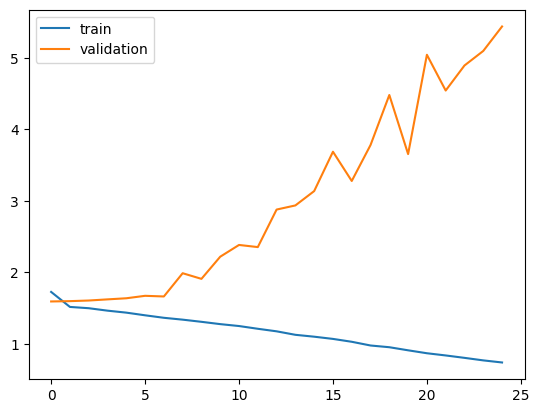

In [111]:
# Plot the loss
plt.plot(loss_train, label='train')
plt.plot(loss_validation, label='validation')
plt.legend()
plt.show()


# Create predictions

In [112]:
# Create a function that takes the model, data loader and device and returns the predictions
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)

            outputs = model(inputs)
            outputs = outputs.argmax(dim=1).cpu().numpy() #Take the class with the highest probability
            predictions.append(outputs)
            targets.append(labels.numpy())

    return np.concatenate(predictions), np.concatenate(targets)

In [123]:
# Create a diffusion matrix of the train and validation data

yPredTrain, yTrainNp = get_predictions(model, train_loader, device)
yPredValidation, yValidationNp = get_predictions(model, validation_loader, device)

In [124]:
yPredValidation.shape

(5046,)

In [125]:
from sklearn.metrics import classification_report

#Print the classification report
print('Training data:')
print(classification_report(yTrainNp, yPredTrain))

print('Validation data:')
print(classification_report(yValidationNp, yPredValidation))


Training data:
              precision    recall  f1-score   support

           0       0.37      0.64      0.47      9820
           1       0.26      0.17      0.20      9690
           2       0.22      0.34      0.27      9677
           3       0.25      0.25      0.25      9746
           4       0.35      0.04      0.07      9726

    accuracy                           0.29     48659
   macro avg       0.29      0.29      0.25     48659
weighted avg       0.29      0.29      0.25     48659

Validation data:
              precision    recall  f1-score   support

           0       0.99      0.35      0.52      4910
           1       0.01      0.19      0.01        16
           2       0.00      0.21      0.00        14
           3       0.00      0.17      0.01        30
           4       0.00      0.00      0.00        76

    accuracy                           0.35      5046
   macro avg       0.20      0.18      0.11      5046
weighted avg       0.97      0.35      0.51  

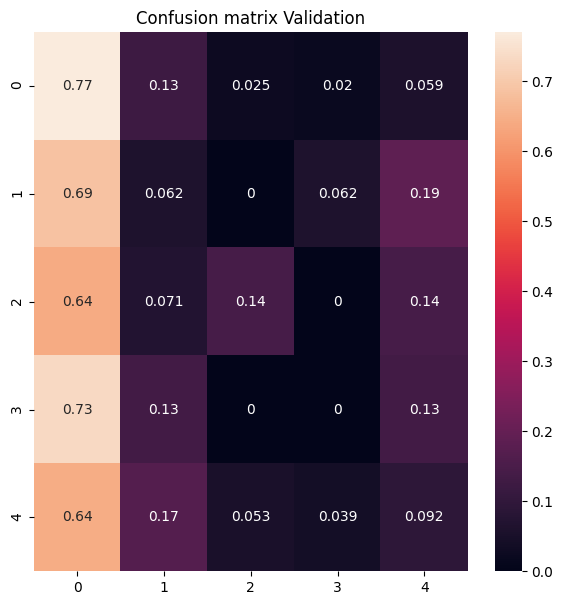

In [116]:
#Import confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yValidationNp, yPredValidation, normalize='true')
plt.figure(figsize = (7,7))
#add labels
plt.title('Confusion matrix Validation')
plt.xlabel('Predicted')
plt.ylabel('True')
#plot the confusion matrix
ax = sns.heatmap(cm, annot=True)

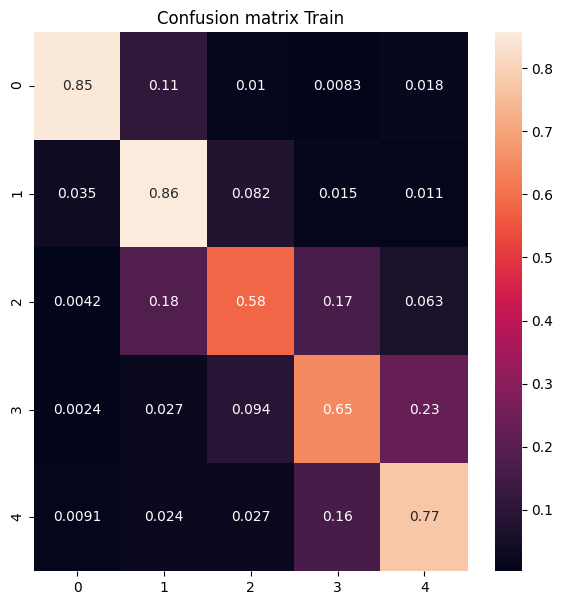

In [117]:
cm = confusion_matrix(yTrainNp, yPredTrain, normalize='true')
plt.figure(figsize = (7,7))
#add labels
plt.title('Confusion matrix Train')
plt.xlabel('Predicted')
plt.ylabel('True')
#plot the confusion matrix
ax = sns.heatmap(cm, annot=True)

In [118]:
checkpoint_path = 'model4.pth'

In [119]:
#Clone the latest model
import copy
model_latest = copy.deepcopy(model)

In [120]:
#Load the best model
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [121]:
model.to(device)

XTransformer(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (categorical_embeddings): ModuleList(
    (0): Embedding(3, 5)
    (1): Embedding(29, 5)
    (2): Embedding(21, 5)
    (3): Embedding(4, 5)
    (4): Embedding(2, 5)
    (5): Embedding(5, 5)
    (6): Embedding(17, 5)
    (7): Embedding(9, 5)
  )
  (input_layer): Linear(in_features=146, out_features=512, bias=True)
  (position_embedding): Embedding(128, 512)
  (layer_norm1): LayerNorm((146,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (input_batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transformer_layers): ModuleList(
    (0-2): 3 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace

In [122]:
from torchinfo import summary
summary(model, (2, XTrain.shape[1], XTrain.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
XTransformer                             [2, 5]                    --
├─ModuleList: 1-1                        --                        --
│    └─Embedding: 2-1                    [2, 128, 5]               15
│    └─Embedding: 2-2                    [2, 128, 5]               145
│    └─Embedding: 2-3                    [2, 128, 5]               105
│    └─Embedding: 2-4                    [2, 128, 5]               20
│    └─Embedding: 2-5                    [2, 128, 5]               10
│    └─Embedding: 2-6                    [2, 128, 5]               25
│    └─Embedding: 2-7                    [2, 128, 5]               85
│    └─Embedding: 2-8                    [2, 128, 5]               45
├─LayerNorm: 1-2                         [2, 128, 146]             292
├─Dropout: 1-3                           [2, 128, 146]             --
├─Linear: 1-4                            [2, 128, 512]             75,264
├─BatchN